# Relative CPU Performance Prediction using Regression Techniques

#### Objective:  

This notebook performs the complete end to end machine learning project involving analysis, model selection, prediction and visualization on the computer hardware dataset, thereby going over the complete data science pipeline. The following steps are considered:

1. Basic imports and data loading
2. Exploratory Data Analysis using Matplotlib or Seaborn
3. Feature Scaling and Train-Test Split
4. Evaluate Different Machine Learning Models
5. Choosing the best model for Prediction
6. Conclusion

#### Dataset:  

The dataset is a Relative CPU Performance Data taken from [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware)  

In [1]:
# Basic Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

### Loading the Dataset

Relative CPU Performance Data is described in terms of machine cycle time, memory size, cache memory. Let's load the data and display the first few rows.

In [2]:
cpu_data = pd.read_csv('machine.data', names = ["vendor name", "Model Name", "MYCT", "MMIN", "MMAX","CACH", "CHMIN", "CHMAX","PRP", "ERP"], delimiter = ',')

Here's a detailed note on the columns of this dataset:
1. vendor name: 30  
(adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

In [3]:
# Display the first 5 rows
cpu_data.head()

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [4]:
# Check for null values in the dataset
print('Size of dataset: {}'.format(cpu_data.shape))
print(cpu_data.isna().sum())

Size of dataset: (209, 10)
vendor name    0
Model Name     0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
ERP            0
dtype: int64


The dataset consists of 209 records with no Null values. 

### Exploratory Data Analysis

##### Statistical Analysis

Given the dataset, it is necessary to carry out statistical analysis to figure out the central tendency (mean), dispersion (variance) and shape of data distribution (std).

In [5]:
cpu_data.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


##### Corelation between different columns of dataset

Let's figure out how the machine cycle time, cache size, estimated and published relative cpu performance are correlated.

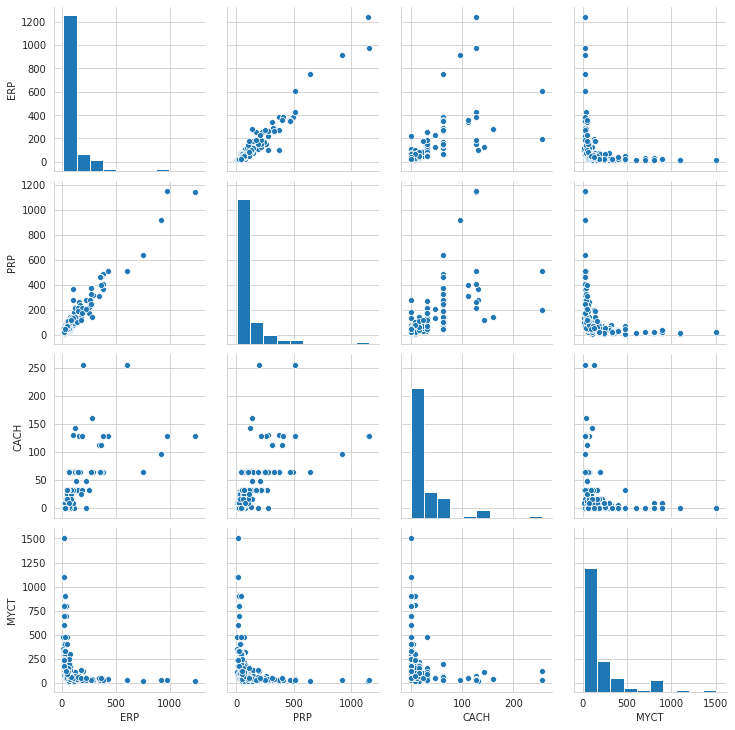

In [6]:
from pandas.plotting import scatter_matrix
attributes = ["ERP","PRP","CACH","MYCT"]
sns.pairplot(cpu_data[attributes], diag_kind = 'hist')

Insights from the pairplot:
1. There is a linear corelation between the Estimated and Published relative cpu performance (ERP, PRP columns). 
2. As the Machine Cycle time (MYCT) increases, the relative cpu performance decreases.
3. The entire fetch-decode-execute cycle time (MYCT) is reduced if the Cache size (CACH) increases.

##### Comparing different Vendors based on the estimated CPU performance

Let's compare the dataset's top 5 vendors cpu performance using density plots.

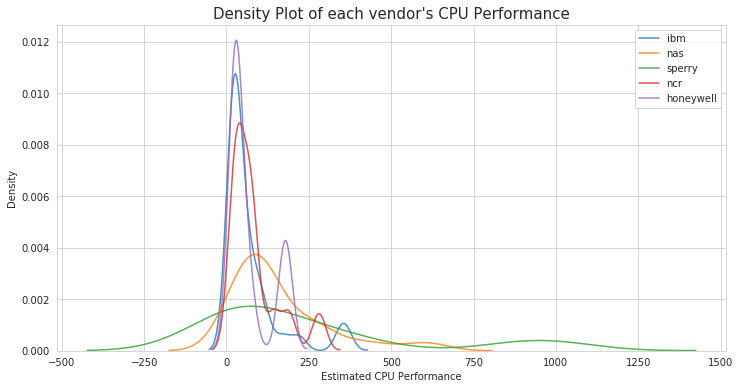

In [7]:
Vendors = cpu_data['vendor name'].value_counts()[:5]

Vendors = list(Vendors.index)
plt.figure(figsize = (12,6))

for i in Vendors:
    subset = cpu_data[cpu_data['vendor name'] == i]
    sns.kdeplot(subset['ERP'],label = i, shade = False, alpha = 0.8);
    
plt.xlabel('Estimated CPU Performance', size = 10)
plt.ylabel('Density', size = 10) 
plt.title("Density Plot of each vendor's CPU Performance", size = 15)
plt.show()

ibm, nas, sperry, ncr and honeywell are the top 5 vendors in this dataset. Based on the density plot there are some noticeable differences at the top and bottom of the chart but, there is still an overlap between ibm, honeywell, ncr. For now let's just focus on the numerical values.

##### Handling the non-integer columns

Since the relative cpu performance depends only on numerical columns, let's drop the non-numeric columns for further processing.

In [8]:
cpu_data.drop(['vendor name', 'Model Name'], axis = 1, inplace = True)

### Feature Scaling and Train-Test Split

Perform feature scaling and split the entire dataset into training and testing set.

In [9]:
X = cpu_data.drop(['ERP','PRP'], axis = 1) # features

# Feature Scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
print('Normalized Features')
print(X_norm[:2])

# Train-Test Split [80 % Training and 20 % Testing]

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X_norm, cpu_data['ERP'], test_size = 0.2, random_state = 101)

print('\nSize of Training set: {}{}'.format(X_train.shape, y_train.shape))
print('Size of Testing set: {}{}'.format(X_test.shape, y_test.shape))

Normalized Features
[[-0.30358614 -0.67502598 -0.49546221  5.69420785  1.66198873  4.23103334]
 [-0.67332952  1.32629082  1.72704937  0.16762947  0.48550899  0.52947875]]

Size of Training set: (167, 6)(167,)
Size of Testing set: (42, 6)(42,)


### Evaluating Models 

Since relative cpu performance is a case of supervised learning (dealing with continuous value), it is necessary to figure out which regression model will be best for prediction. In this section, different regression models namely Linear, Lasso, Ridge, Stochastic Gradient Descent, K-NN are trained on the training set, which are then evaluated on test sets. Criteria for choosing the best model is based on the metric ~ Root Mean Square Error (RMSE). The model with least RMSE will be chosen as the best model for prediction.

In [10]:
def rmse (y_true, y_pred):
    """ Function to return the Root Mean Square Error """ 
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def model_test(model):
    """
    Generic function that:
    1. Fits the given model on training sets (X_train, y_train)
    2. Predicts the hypothesis on test input (X_test)
    3. Calculates the root mean square error (y_test, hypothesis)
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    model_rsme = rmse(y_test, predictions)
    return model_rsme

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

In [12]:
### Case 1: Linear Regression

lr = LinearRegression()
lr_rsme = model_test(lr)
print("Root Mean Square Error for linear regression:", lr_rsme)

Root Mean Square Error for linear regression: 41.1748843930508


In [13]:
### Case 2: Lasso Regression

lr_lasso = Lasso(alpha = 0.3)
lasso_rmse = model_test(lr_lasso)
print("Root Mean Square Error for lasso regression:", lasso_rmse)

Root Mean Square Error for lasso regression: 41.01864618094856


In [14]:
### Case 3: Ridge Regression

lr_ridge = Ridge(fit_intercept=True, alpha = 0.3)
ridge_rmse = model_test(lr_ridge)
print("Root Mean Square Error for ridge regression:", ridge_rmse)

Root Mean Square Error for ridge regression: 41.0579404364606


In [15]:
### Case 4: Stochastic Gradient Descent

sgdreg = SGDRegressor(penalty = 'l2', alpha = 0.15, max_iter = 200)
sgd_rmse = model_test(sgdreg)
print("Root Mean Square Error for SGD regression:", sgd_rmse)

Root Mean Square Error for SGD regression: 34.75623126854453


In [16]:
### Case 5: K Nearest Neighbours

knn = KNeighborsRegressor(n_neighbors=5)
knn_rsme = model_test(knn)
print(" the root mean squared error for K nearest neighbors is:", knn_rsme)

 the root mean squared error for K nearest neighbors is: 43.65096409779132


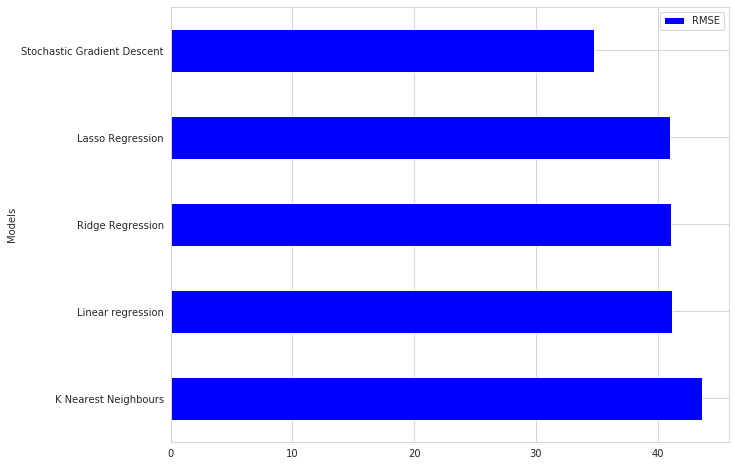

In [17]:
model_comparison = pd.DataFrame({"Models" : ["Linear regression", "Lasso Regression", "Ridge Regression", "Stochastic Gradient Descent", "K Nearest Neighbours"],"RMSE" : [lr_rsme, lasso_rmse, ridge_rmse, sgd_rmse, knn_rsme]})

model_comparison.sort_values("RMSE", ascending = False).plot(x = "Models", y = "RMSE", kind = "barh", figsize = (10,8), color = 'blue')

The plot above shows that Stochastic Gradient Descent is the best since it has the least RMSE. 

Stochastic Gradient Descent is often used for large datasets(sample size > 10000000). Since the sample size of this dataset is just 209 and all features are linearly correlated, either Linear, Lasso or Ridge could be choosen for prediction. Let's use simple Linear Regression.

### Chosen Prediction Model: Linear Regression

In [18]:
model = LinearRegression()

# train and fit the model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
MYCT,18.208130
MMIN,54.284968
MMAX,84.054722
CACH,15.310554
CHMIN,-2.195786
CHMAX,33.852399


Interpreting the coefficients:  
Holding all other features fixed, a 1 unit increase in MYCT (Machine cycle time) is associated with an increase in CPU performance by 18.20.  
Holding all other features fixed, a 1 unit increase in MMax (Maximum Main memory) is associated with an
increase in CPU performace by 84.05.  
Holding all other features fixed, a 1 unit increase in CACH (Cache memory) is associated with an
increase in CPU performace by 15.31.  

In [20]:
### Saving the Model

from sklearn.externals import joblib
joblib.dump(model, 'cpuPerformance_Model.pkl')
print ("Model Saved...")

Model Saved...


/home/supriya/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Linear Regression Model Prediction')

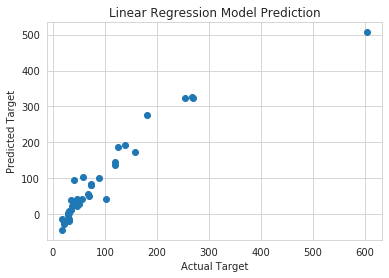

In [21]:
### Prediction

hypothesis = model.predict(X_test)

plt.scatter(y_test, hypothesis)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Linear Regression Model Prediction')

Since the plot is linear, there exists a strong corelation between actual and predicted value. Let's also plot the residue between actual and predicted value.

Text(0.5, 1.0, 'Residue')

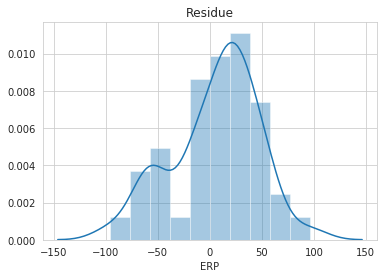

In [22]:
sns.distplot((y_test - hypothesis), bins = 10)
plt.title('Residue')

In [23]:
### lets check the variance of the predicted model

from sklearn import metrics
value = metrics.explained_variance_score(y_test, hypothesis)

print('Chosen Model explains {:2f} % variance'.format(value * 100))

Chosen Model explains 84.506265 % variance


### Conclusions

At the end of this analysis, the conclusion is that:  
  
- The best model to choose based on the features is Linear Regression
- If the sample size of dataset increases to an extremely large value then Stochastic Gradient Descent could be choosen as the best alternative to Linear Regression
- There is a strong correlation between predicted and actual values.

##### Thats it! Happy Learning :)